In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)

In [1]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [2]:
tf.keras.backend.set_floatx("float64")

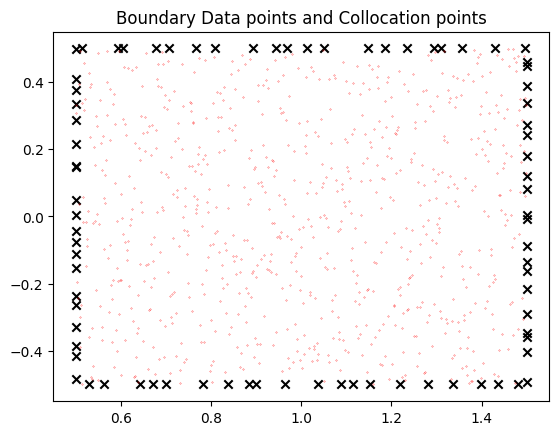

In [3]:
# We a Grad-Shafranov equation -> Delta* u = f(x, y, u) 
# where Delta* is the elliptic laplacian: Delta* u = u_xx - u_x/x + u_yy 
# and f is a function to be specified that can be (x**n y**m) or
# somme non linear function ........................
# ...............................................................

# Note that Hard constraint for imposing the boundary conditions give much
# better results here ................
#.......................................

### data generation on Boundaries if needed ...
n_bc = 4
n_data_per_bc = 20
#
engine = qmc.LatinHypercube(d=1)
data = np.zeros([4,n_data_per_bc , 3])

for i, j in zip(range(n_bc), [0., 1., 0, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.) * 1
    #points = np.linspace(0, +1, n_data_per_bc)
    if i < 2:
        data[i, :, 0] = j + 0.5
        data[i, :, 1] = (points - 0.5)
    else:
        data[i, :, 0] = points + 0.5
        data[i, :, 1] = (j -0.5)

# BC Values -> zero here ! ........
# normalized in [0, 1]
data[0, :, 2] = 0.
data[1, :, 2] = 0.
data[2, :, 2] = 0.
data[3, :, 2] = 0.

data = data.reshape(n_data_per_bc * n_bc, 3)
#

x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])
#

# Data collocation points ..... we use a rectangular domain ... se paper
Nc = 800
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 1 * (colloc -0)

#
colloc[:, 0] = (colloc[:, 0] + 0.5) 
colloc[:, 1] = (colloc[:, 1] - 0.5)
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

#

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="r", label="CP")
plt.show()

#

x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])

In [4]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=10, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [5]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 5, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21    

In [6]:
# um must be used for hard constraints instead of u (for soft ones) ....

@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

@tf.function
def um(x, y):
    um = model(tf.concat([x, y], axis=1))
    um=(x-1.5)*(x-0.5)*(y+0.5)*(y-0.5)*um
    return um

In [7]:
# Residual equation to be defined .........
@tf.function
def f(x, y):
    u0 = um(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    
    # You must choose the function F = x f as we multiply the equation by x to avoid 1/x in the original form
    
    F = x*u_xx + x*u_yy - u_x + x *1       
    F = x*u_xx + x*u_yy - u_x + x*(x**2*y**3 ) 
    #F = x*u_xx + x*u_yy - u_x + x*(x**3*y**2 )
    
    ##F = x*u_xx + x*u_yy - u_x + x*0.1*(1 - 0.70199*x*x)*(1-u0)**0.6

    ##F = x*u_xx + x*u_yy - u_x + x**2
     
    return tf.reduce_mean(tf.square(F))



In [8]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

    0, 0.02604321
  200, 0.00403629
  400, 0.00358706
  600, 0.00334162
  800, 0.00309281
 1000, 0.00230994
 1200, 0.00204732
 1400, 0.00176996
 1600, 0.00158951
 1800, 0.00143021
 2000, 0.00128438
 2200, 0.00116443
 2400, 0.00105811
 2600, 0.00095266
 2800, 0.00087255
 3000, 0.00081853
 3200, 0.00077309
 3400, 0.00073233
 3600, 0.00069501
 3800, 0.00065961
 4000, 0.00062995
 4200, 0.00060229
 4400, 0.00057555
 4600, 0.00055233
 4800, 0.00053002
 5000, 0.00051375
 5200, 0.00048816
 5400, 0.00046947
 5600, 0.00045200
 5800, 0.00043713
 6000, 0.00042313
 6200, 0.00041177
 6400, 0.00039737
 6600, 0.00038983
 6800, 0.00037210
 7000, 0.00035967
 7200, 0.00035621
 7400, 0.00033434
 7600, 0.00032296
 7800, 0.00031222
 8000, 0.00034430
 8200, 0.00029219
 8400, 0.00028339
 8600, 0.00028791
 8800, 0.00026722
 9000, 0.00026048
 9200, 0.00025284
 9400, 0.00024659
 9600, 0.00024057
 9800, 0.00023512
10000, 0.00022955
10200, 0.00022450
10400, 0.00021944
10600, 0.00021472
10800, 0.00020971
11000, 0.0

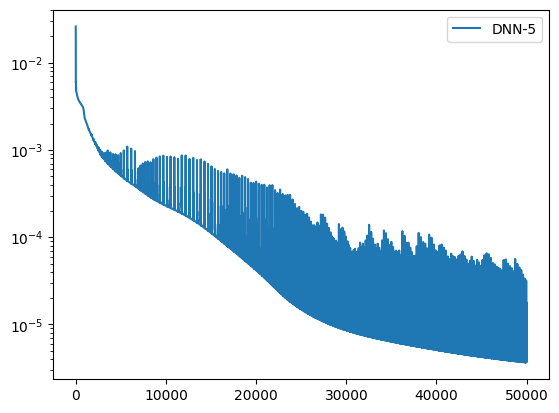

In [9]:
loss = 0
epochs = 50000
opt = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4)
epoch = 0
loss_values = np.array([])
#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = um(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        # for lagaris bc ... only L is needed and um intead of u id used above ...
        loss = L 
        
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.8f}")

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

In [10]:
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])



/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_3461/829566544.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_3461/829566544.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_3461/829566544.py:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(224)
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_3461/829566544.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


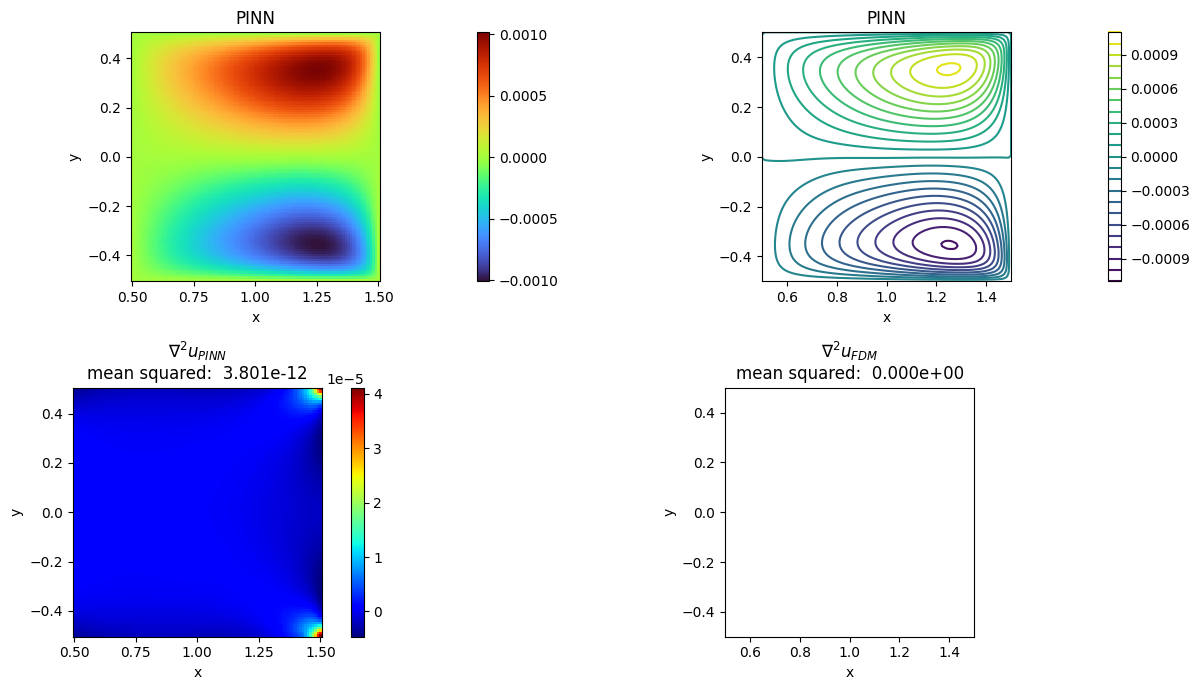

(0.5, 1.5, -0.5, 0.5)

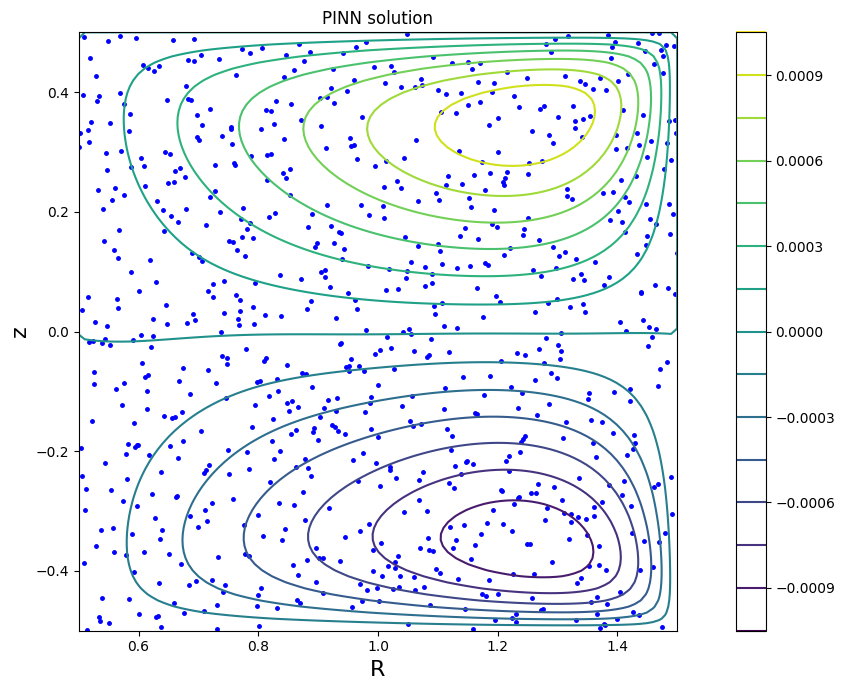

In [11]:
### plotting the results ........
#plt.figure("", figsize=(16, 8))
plt.figure("", figsize=(14, 7))

#
X = np.linspace(0.5, +1.5, n)
Y = np.linspace(-0.5, +0.5, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

# solution predicted .....
S = um(X_T, Y_T)
S = S.numpy().reshape(n, n)

#
plt.subplot(221)
plt.pcolormesh(X0, Y0, S, cmap="turbo")
plt.colorbar(pad=-0.25)
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN")
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(0.5, 1.5, n)
y = np.linspace(-0.5, 0.5, n)
x, y = np.meshgrid(x, y)
#
plt.subplot(222)
#plt.pcolormesh(x, y, T, cmap="magma")
plt.contour(X0, Y0, S,20)
plt.colorbar(pad=-0.25)
plt.title(r"PINN")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0.5, 1.5)
plt.ylim(-0.5, 0.5)
plt.tight_layout()
plt.axis("square")
#plt.savefig("heat01.png")
#
plt.subplot(223)
pinn_grad = np.gradient(np.gradient(S, axis=0), axis=1)
sigma_pinn = (pinn_grad**2).mean()
plt.pcolormesh(X0, Y0, pinn_grad, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"${\nabla^{2}{u_{PINN}}}$" + f"\nmean squared: {sigma_pinn: .3e}")
plt.tight_layout()
plt.axis("square")
###
x = np.linspace(0.5, +1.5, n)
y = np.linspace(-0.5, 0.5, n)
x, y = np.meshgrid(x, y)
#
plt.subplot(224)
fdm_grad = np.gradient(np.gradient(T, axis=0), axis=1)
sigma_fdm = (fdm_grad**2).mean()
#plt.pcolormesh(x, y, fdm_grad, cmap="jet")
plt.colorbar()
plt.title(r"${\nabla^{2}{u_{FDM}}}$" + f"\nmean squared: {sigma_fdm: .3e}")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0.5, +1.5)
plt.ylim(-0.5, +0.5)
plt.tight_layout()
plt.axis("square")
#plt.savefig("heat01.png")
plt.show()



plt.figure("", figsize=(14, 7))

plt.contour(X0, Y0, S,16)
plt.colorbar(pad=-0.25)
plt.scatter(colloc[:, 0], colloc[:, 1], s=25, marker=".", c="b", label="CP")
plt.title(r"PINN solution")
plt.xlabel("R",fontsize=16)
plt.ylabel("z",fontsize=16)
plt.xlim(0.5, 1.5)
plt.ylim(-0.5, 0.5)
plt.tight_layout()
plt.axis("square")

#

